In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/cuda/diabetes.csv')

In [37]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [38]:
!pip install torch

In [39]:
import torch
torch.cuda.is_available()

True

In [40]:
a = torch.rand(10000,10000)
b = torch.rand(10000,10000)

import time
start = time.time()
a.matmul(b)
end = time.time()
print("{} seconds".format(end - start))

27.09530997276306 seconds


In [41]:
a = a.cuda()
b = b.cuda()

start = time.time()
a.matmul(b)
end = time.time()
print("{} seconds".format(end - start))


0.0014548301696777344 seconds


In [42]:
print(type(a),type(b))

<class 'torch.Tensor'> <class 'torch.Tensor'>


In [43]:
X = df.drop('Outcome',axis=1)
y = df['Outcome']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
##### Creating Tensors
X_train=torch.FloatTensor(X_train_scaled).cuda()
X_test=torch.FloatTensor(X_test_scaled).cuda()
y_train=torch.LongTensor(y_train.values).cuda()
y_test=torch.LongTensor(y_test.values).cuda()



In [44]:
from torch import nn
import torch.nn.functional as F

class ANN_Model(nn.Module):
    def __init__(self,input_features=8,hidden1=6,hidden2=4,out_features=2):
        super().__init__()
        self.f_connected1=nn.Sequential( nn.Linear(input_features,hidden1), nn.ReLU())
        self.f_connected2=nn.Sequential( nn.Linear(hidden1,hidden2),nn.ReLU())
        self.out=nn.Linear(hidden2,out_features)
    def forward(self,x):
        x=F.relu(self.f_connected1(x))
        x=F.relu(self.f_connected2(x))
        x=self.out(x)
        return x

In [45]:
####instantiate my ANN_model
torch.manual_seed(20)
model=ANN_Model()
print(model)

ANN_Model(
  (f_connected1): Sequential(
    (0): Linear(in_features=8, out_features=6, bias=True)
    (1): ReLU()
  )
  (f_connected2): Sequential(
    (0): Linear(in_features=6, out_features=4, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=4, out_features=2, bias=True)
)


In [46]:
model.parameters

<bound method Module.parameters of ANN_Model(
  (f_connected1): Sequential(
    (0): Linear(in_features=8, out_features=6, bias=True)
    (1): ReLU()
  )
  (f_connected2): Sequential(
    (0): Linear(in_features=6, out_features=4, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=4, out_features=2, bias=True)
)>

In [47]:
y_train.device

device(type='cuda', index=0)

In [48]:
for i in model.parameters():
    print(i.is_cuda)

False
False
False
False
False
False


In [49]:
model=model.cuda()

In [50]:
model

ANN_Model(
  (f_connected1): Sequential(
    (0): Linear(in_features=8, out_features=6, bias=True)
    (1): ReLU()
  )
  (f_connected2): Sequential(
    (0): Linear(in_features=6, out_features=4, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=4, out_features=2, bias=True)
)

In [51]:
for i in model.parameters():
    print(i.is_cuda)

True
True
True
True
True
True


In [52]:
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.003)

In [53]:
import time
start_time=time.time()
epochs=8000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred=model.forward(X_train)
    loss=loss_function(y_pred,y_train)
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(time.time()-start_time)

Epoch number: 1 and the loss : 0.6674039959907532
Epoch number: 11 and the loss : 0.6341993808746338
Epoch number: 21 and the loss : 0.6050453186035156
Epoch number: 31 and the loss : 0.5806847214698792
Epoch number: 41 and the loss : 0.5587883591651917
Epoch number: 51 and the loss : 0.5399641990661621
Epoch number: 61 and the loss : 0.5245302319526672
Epoch number: 71 and the loss : 0.5115704536437988
Epoch number: 81 and the loss : 0.5012460947036743
Epoch number: 91 and the loss : 0.4928086996078491
Epoch number: 101 and the loss : 0.4860762357711792
Epoch number: 111 and the loss : 0.4804898202419281
Epoch number: 121 and the loss : 0.47572827339172363
Epoch number: 131 and the loss : 0.47161364555358887
Epoch number: 141 and the loss : 0.4677990972995758
Epoch number: 151 and the loss : 0.463825523853302
Epoch number: 161 and the loss : 0.46017590165138245
Epoch number: 171 and the loss : 0.4572939872741699
Epoch number: 181 and the loss : 0.45453891158103943
Epoch number: 191 an

Text(0.5, 0, 'Epoch')

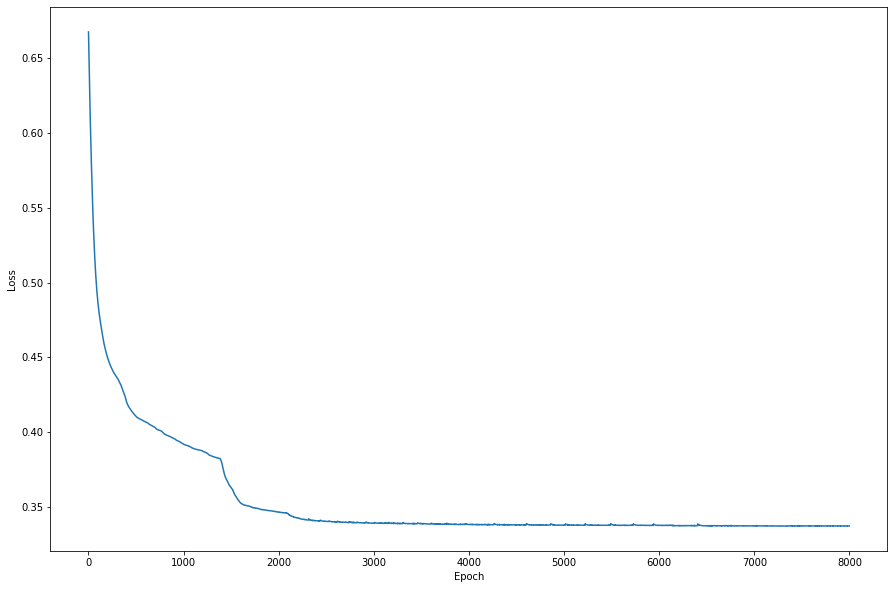

In [54]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(range(epochs),final_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

In [55]:
predictions=[]
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_pred=model(data)
        predictions.append(y_pred.argmax().item())
        print(y_pred.argmax().item())

1
0
0
1
0
0
1
0
1
0
1
1
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
1
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
1
1
1
0
0
0
0
0
1
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
1
1
0
0
0
0
1
1
0
0
0
1
0
0
0
1
1
1
0
1
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0


In [56]:
type(predictions)

list

In [57]:
type(y_test)

torch.Tensor

In [58]:
y_test1 = y_test.cpu().numpy()

In [59]:
y_test1

array([1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [60]:
import numpy as np
predictions1 = np.array(predictions)

In [61]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test1,predictions1)
cm

array([[96, 11],
       [21, 26]])

Text(69.0, 0.5, 'Predicted Values')

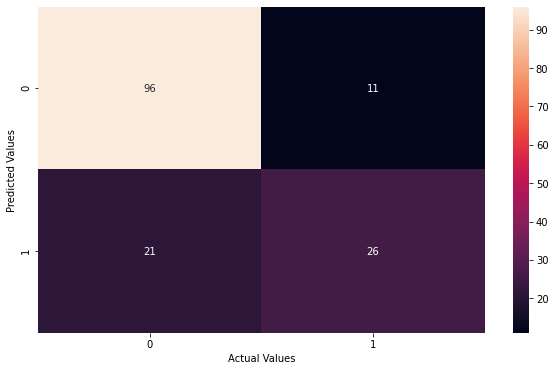

In [62]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(cm,annot=True)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [63]:
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test1,predictions1)
score

0.7922077922077922

In [64]:
########################################### outlier removal ###############################################
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/cuda/diabetes.csv')

In [65]:
data.loc[data['Glucose'] <= 72,'Glucose']  = 72
data.loc[data['BloodPressure'] <= 40,'BloodPressure']  = 40
data.loc[data['BloodPressure'] > 98,'BloodPressure']  = 98
data.loc[data['SkinThickness'] <= 3,'SkinThickness']  = 3
data.loc[data['SkinThickness'] > 44,'SkinThickness']  = 44
data.loc[data['Insulin'] > 172 ,'Insulin']  = 172
data.loc[data['BMI'] <= 20,'BMI']  = 20
data.loc[data['BMI'] > 44 ,'BMI']  = 44
data.loc[data['DiabetesPedigreeFunction'] > 0.96 ,'DiabetesPedigreeFunction']  = 0.96

['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


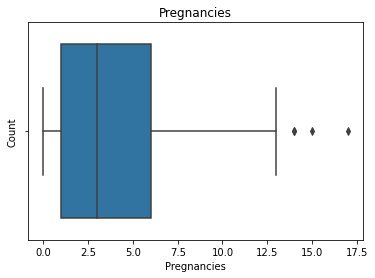

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


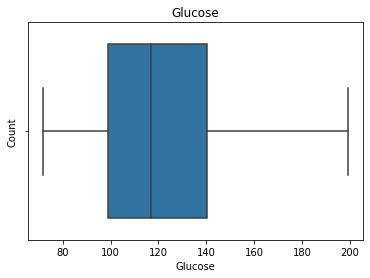

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


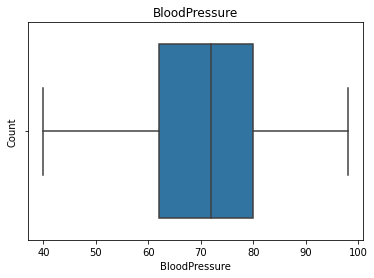

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


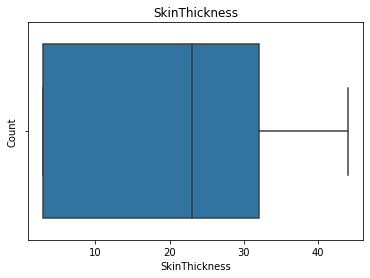

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


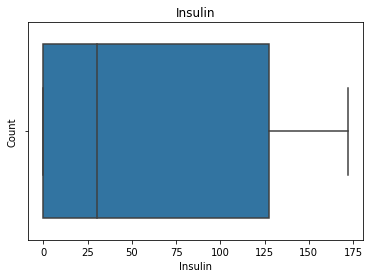

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


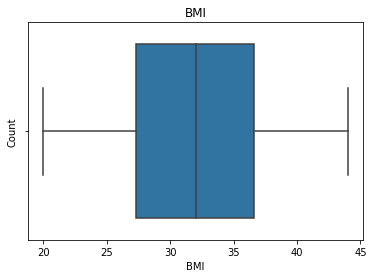

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


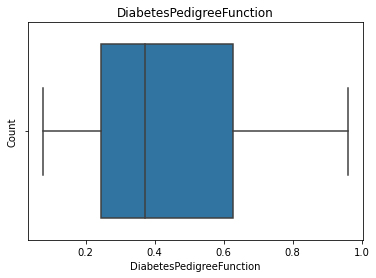

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


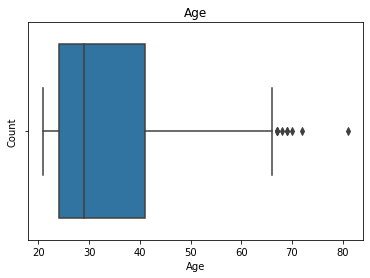

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
num_features = [i for i in data.columns if i not in 'Outcome']
print(num_features)
for feature in num_features:
    data1=data.copy()
    sns.boxplot(data1[feature])
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

In [67]:
X = data.drop('Outcome',axis=1)
y = data['Outcome']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)
##### Creating Tensors
X_train=torch.FloatTensor(X_train_scaled).cuda()
X_test=torch.FloatTensor(X_test_scaled).cuda()
y_train=torch.FloatTensor(y_train.values).cuda()
y_test=torch.FloatTensor(y_test.values).cuda()



In [68]:
import torch
from torch import nn
import torch.nn.functional as F

class ANN_Model1(nn.Module):
    def __init__(self,input_features=8,hidden1=4,out_features=1):
        super().__init__()
        self.f_connected1=nn.Linear(input_features,hidden1)
        
        #self.f_connected2=nn.Sequential( nn.Linear(hidden1,hidden2),nn.ReLU())
        
        self.out=nn.Linear(hidden1,out_features)
    def forward(self,x):
        x=F.relu(self.f_connected1(x))
        #x=F.relu(self.f_connected2(x))
        x = torch.sigmoid(self.out(x))
        #x=self.out(x)
        return x
		
		
####instantiate my ANN_model
torch.manual_seed(20)
model_ot=ANN_Model1()
print(model_ot)

model_ot_cuda=model_ot.cuda()

loss_function=nn.BCELoss()
optimizer=torch.optim.RMSprop(model_ot_cuda.parameters(),lr=0.09,alpha=0.8)

import time
start_time=time.time()
epochs=20000
final_losses=[]
for i in range(epochs):
    i=i+1
    y_pred_ot=model_ot_cuda.forward(X_train)
    loss=loss_function(y_pred_ot,y_train.reshape(-1,1))
    final_losses.append(loss)
    if i%10==1:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(time.time()-start_time)

ANN_Model1(
  (f_connected1): Linear(in_features=8, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=True)
)
Epoch number: 1 and the loss : 0.6820880770683289
Epoch number: 11 and the loss : 0.4607026278972626
Epoch number: 21 and the loss : 0.44261929392814636
Epoch number: 31 and the loss : 0.43732354044914246
Epoch number: 41 and the loss : 0.4333278238773346
Epoch number: 51 and the loss : 0.4307858645915985
Epoch number: 61 and the loss : 0.4333767294883728
Epoch number: 71 and the loss : 0.4305442273616791
Epoch number: 81 and the loss : 0.4296934902667999
Epoch number: 91 and the loss : 0.432667076587677
Epoch number: 101 and the loss : 0.43284574151039124
Epoch number: 111 and the loss : 0.43278199434280396
Epoch number: 121 and the loss : 0.43220654129981995
Epoch number: 131 and the loss : 0.4309331774711609
Epoch number: 141 and the loss : 0.42918986082077026
Epoch number: 151 and the loss : 0.43384209275245667
Epoch number: 161 and the loss : 0

Text(0.5, 0, 'Epoch')

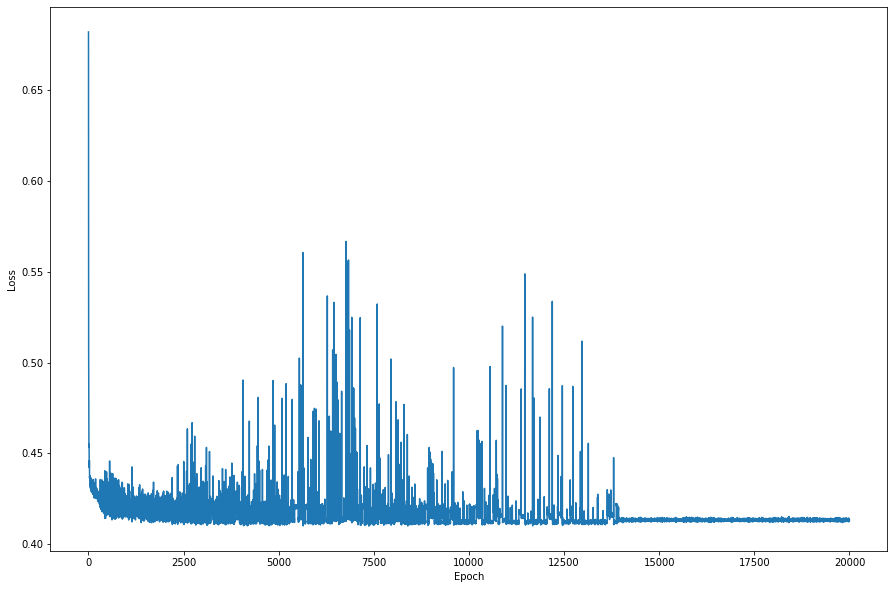

In [69]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(range(epochs),final_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')



In [70]:
predictions_ot=[]
with torch.no_grad():
    for i,data1 in enumerate(X_test):
        y_pred_ot=model_ot_cuda(data1)
        predictions_ot.append(y_pred_ot.argmax().item())
        #print(y_pred_ot.argmax().item())

y_test_ot = y_test.cpu().numpy()

import numpy as np
predictions_ot = np.array(predictions_ot)
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test_ot,predictions_ot)
print("confusion matrix\n",cm)
from sklearn.metrics import accuracy_score
score=accuracy_score(y_test_ot,predictions_ot)
print("accuray score",score)

confusion matrix
 [[107   0]
 [ 47   0]]
accuray score 0.6948051948051948
